## Import libraries

In [1]:
import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score
import random
import seaborn as sns

#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

## Explore dataset

In [2]:
df = pd.read_csv("songs_byplaylist_bygenres.csv")
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,7.336300e+04
mean,0.571666,0.585020,-9.606646,0.084714,0.337416,0.181970,0.184051,0.474739,119.519258,2.299611e+05
std,0.185722,0.268684,6.761314,0.091120,0.344895,0.336221,0.155988,0.259037,30.233595,1.622000e+05
min,0.000000,0.000000,-53.436000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.229000e+03
25%,0.459000,0.408000,-11.225000,0.036100,0.028100,0.000000,0.095800,0.265000,95.990000,1.773700e+05
50%,0.590000,0.629000,-7.521000,0.048700,0.194000,0.000090,0.119000,0.472000,119.924000,2.121220e+05
75%,0.708000,0.803000,-5.353500,0.087900,0.632000,0.102000,0.220000,0.681000,139.284500,2.524130e+05
max,0.987000,1.000000,1.358000,0.961000,0.996000,1.000000,0.995000,0.999000,240.107000,6.000661e+06


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73365 entries, 0 to 73364
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      73363 non-null  float64
 1   energy            73363 non-null  float64
 2   loudness          73363 non-null  float64
 3   speechiness       73363 non-null  float64
 4   acousticness      73363 non-null  float64
 5   instrumentalness  73363 non-null  float64
 6   liveness          73363 non-null  float64
 7   valence           73363 non-null  float64
 8   tempo             73363 non-null  float64
 9   id                73363 non-null  object 
 10  duration_ms       73363 non-null  float64
dtypes: float64(10), object(1)
memory usage: 6.2+ MB


##### decision we made regarding the columns to keep or not in the dataset

- In previous analysis we noticed that the duration_ms seem to be defining an entire cluster by itself. The previous models were'nt working well so we decided to get rid of this column


##### None values are not allowed in the dataset for the elbow analysis so we need to drop them

##### Duplicates of same songs could affect the mean calculated to establish the clusters

In [4]:
#drop specific column
df = df.drop('duration_ms', axis=1)
df = df.drop('loudness', axis = 1)
# drop null values rows
df.dropna(axis = 0, inplace = True)
#check for duplicates
before = len(df)
data = df.drop_duplicates()
after = len(df)
print('Number of duplicate records dropped: ', str(before - after))

Number of duplicate records dropped:  0


In [5]:
#we just realised that we can't filter out the duplicates because songs with same artist and title could have different ids if they are in different playlists! 
# we sould have used this to select the real duplicates before extracting the data
# duplicates_names_artist = df[df.duplicated(['name', 'artists'])]

In [6]:
df.set_index('id', inplace=True)
df.head()

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo
id,,,,,,,,
5CQHTuNbYlEA4fZdxQ4PMi,0.585,0.239,0.0309,0.697,0.001330,0.159,0.0933,101.182
3LHg768dEKqJKht2uPTlVR,0.463,0.368,0.0480,0.376,0.000000,0.149,0.7500,141.974
3bHhUEOTIbezeZ856R0BX5,0.561,0.327,0.0327,0.902,0.000469,0.111,0.2980,161.858
2hKdd3qO7cWr2Jo0Bcs0MA,0.481,0.638,0.0276,0.153,0.000000,0.154,0.4970,79.064
615auKcis6sGDrHk6UTeog,0.643,0.495,0.0292,0.421,0.001230,0.082,0.3190,127.219


## Scale the df

In [7]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)
df_scaled_df = pd.DataFrame(df_scaled, columns = df.columns)
display(df.head())
print()
display(df_scaled_df.head())

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo
id,,,,,,,,
5CQHTuNbYlEA4fZdxQ4PMi,0.585,0.239,0.0309,0.697,0.001330,0.159,0.0933,101.182
3LHg768dEKqJKht2uPTlVR,0.463,0.368,0.0480,0.376,0.000000,0.149,0.7500,141.974
3bHhUEOTIbezeZ856R0BX5,0.561,0.327,0.0327,0.902,0.000469,0.111,0.2980,161.858
2hKdd3qO7cWr2Jo0Bcs0MA,0.481,0.638,0.0276,0.153,0.000000,0.154,0.4970,79.064
615auKcis6sGDrHk6UTeog,0.643,0.495,0.0292,0.421,0.001230,0.082,0.3190,127.219


,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.071794,-1.287845,-0.590588,1.042597,-0.537269,-0.160595,-1.472534,-0.606523
1,-0.585107,-0.807723,-0.402922,0.111873,-0.541225,-0.224703,1.062640,0.742713
2,-0.057432,-0.960320,-0.570834,1.636984,-0.539830,-0.468314,-0.682295,1.400397
3,-0.488187,0.197183,-0.626805,-0.534704,-0.541225,-0.192649,0.085940,-1.338099
4,0.384091,-0.335045,-0.609245,0.242349,-0.537566,-0.654227,-0.601225,0.254677


## Chosing K

### elbow method

In [ ]:
K = range(35, 55)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(df_scaled_df)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Training a K-Means model with 35 clusters! 



KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


Training a K-Means model with 36 clusters! 

Training a K-Means model with 37 clusters! 

Training a K-Means model with 38 clusters! 

Training a K-Means model with 39 clusters! 

Training a K-Means model with 40 clusters! 



## Silouhette

K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(df_scaled_df)
    
    filename = "kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(df_scaled_df, kmeans.predict(df_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

## Clustering the songs with K-Means

In [ ]:
kmeans = KMeans(n_clusters=42, random_state=1234)
kmeans.fit(df_scaled_df)

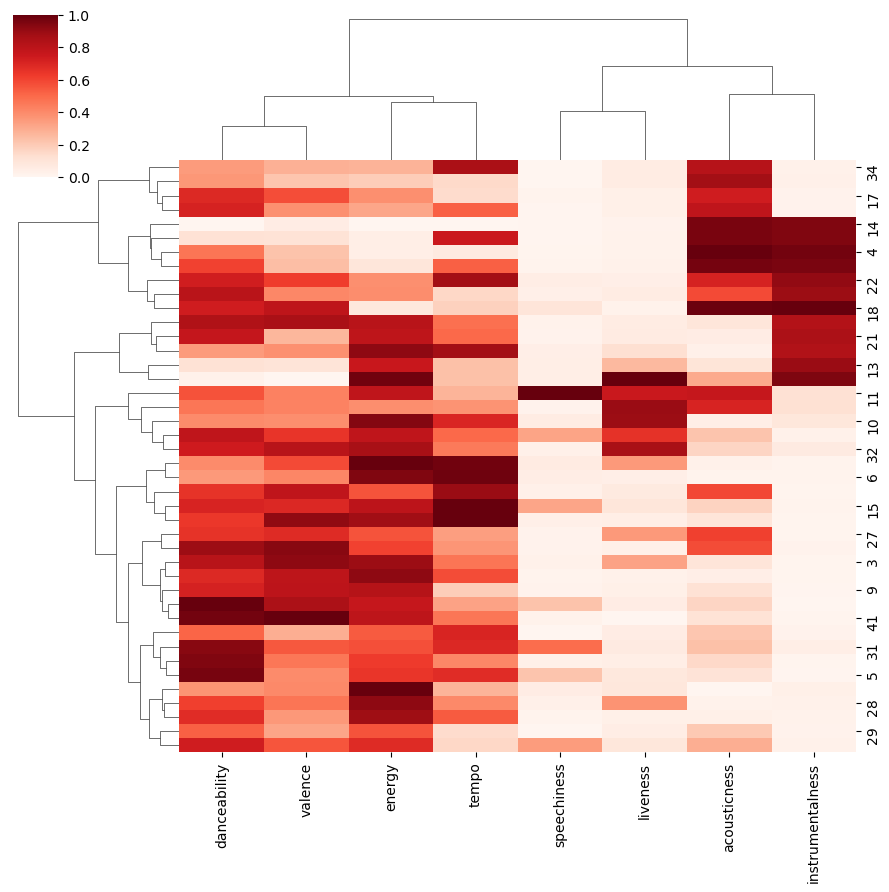

In [237]:
import seaborn as sns
columns_no_id = ["danceability","energy","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo"]
#sns.heatmap(pd.DataFrame(kmeans.cluster_centers_,columns = columns_no_id),cmap="Reds")
sns.clustermap(pd.DataFrame(kmeans.cluster_centers_,columns = columns_no_id), cmap='Reds', standard_scale=1, method='ward', figsize=(9, 9))

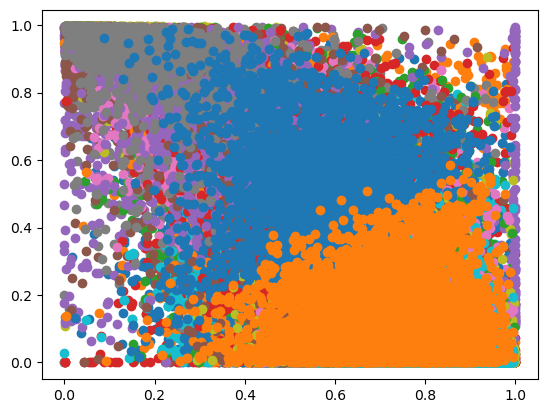

In [238]:
# assign a cluster to each example
labels = kmeans.predict(df_scaled_df) #same as kmeans.labels_
clusters = np.unique(labels)
for cluster in clusters:
    row_ix = np.where(labels == cluster)
    pyplot.scatter(df.to_numpy()[row_ix, 1], df.to_numpy()[row_ix, 3]) #1 and 3 define the index of colums axes to be used for the visualization. But know that all the columns are ploted
pyplot.show()

Now we have our "model", let's get the clusters and how many observations has each cluster.

In [239]:
clusters = kmeans.predict(df_scaled_df)
pd.Series(clusters).value_counts().sort_index()

0     1161
1     3337
2     1689
3     2899
4     1527
5     1556
6     2300
7     2238
8     1781
9     3294
10     712
11     132
12    1353
13     742
14    2425
15    1331
16     574
17    2137
18     840
19    1902
20    2330
21    1334
22     774
23     575
24     334
25    1507
26    2562
27    1268
28    2287
29    2317
30    2295
31     928
32    1114
33    1782
34    1512
35    1392
36    3410
37    1421
38     750
39    2929
40    2546
41    4066
dtype: int64

Now let's see to which group was assigned every song

In [240]:
df["cluster"] = clusters
df

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
id,,,,,,,,,
5CQHTuNbYlEA4fZdxQ4PMi,0.585,0.239,0.0309,0.697000,0.001330,0.159,0.0933,101.182,7
3LHg768dEKqJKht2uPTlVR,0.463,0.368,0.0480,0.376000,0.000000,0.149,0.7500,141.974,33
3bHhUEOTIbezeZ856R0BX5,0.561,0.327,0.0327,0.902000,0.000469,0.111,0.2980,161.858,34
2hKdd3qO7cWr2Jo0Bcs0MA,0.481,0.638,0.0276,0.153000,0.000000,0.154,0.4970,79.064,29
615auKcis6sGDrHk6UTeog,0.643,0.495,0.0292,0.421000,0.001230,0.082,0.3190,127.219,30
...,...,...,...,...,...,...,...,...,...
0uctKVLlfFjhYRnJaDaYXM,0.436,0.915,0.0562,0.000086,0.000005,0.348,0.4210,162.049,2
4O7PMEWkbHDS1TJhH0ZBqi,0.490,0.905,0.0598,0.000016,0.000757,0.341,0.5590,90.974,28
6JKwPN8ThWw1ofH8BFMzXV,0.579,0.949,0.0611,0.000037,0.000053,0.101,0.6390,125.126,36


# Saving with pickle

In [241]:
import pickle

#scaler = StandardScaler()
#model = KMeans()

with open("song_recom_scaler.pickle", "wb") as f: 
    pickle.dump(scaler,f) 

with open("song_recom_kmeans.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [242]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: #rb in this cas is reading permission
            return pickle.load(f) 
        
    except FileNotFoundError: # if we don't add this error it will give an error and the running will stop
        print("File not found!") 


...

## Extract csv files by clusters

In [243]:
def extract_dataframes_by_clusters(df, cluster):
    df2 = df.reset_index()
    unique_clusters = df2[cluster].unique() 
    dfs_bycluster = {}
    for value in unique_clusters:
        dfs_bycluster[value] = df2[df2[cluster] == value] # Extract the DataFrame for each unique value
        file_name = f"{cluster}_{value}.csv"
        dfs_bycluster[value].to_csv(file_name, index=False)
    return dfs_bycluster

cluster = 'cluster'
extract_dataframes_by_clusters(df, cluster)

{7:                            id  danceability  energy  speechiness  \
 0      5CQHTuNbYlEA4fZdxQ4PMi         0.585   0.239       0.0309   
 31     7jJH5jAOUvR0FxkbYBmAQA         0.390   0.128       0.0518   
 49     5sra5UY6sD658OabHL3QtI         0.484   0.368       0.0341   
 70     2Uj2BjZXVv9WvYFEVl8TDi         0.470   0.296       0.0328   
 98     28cnXtME493VX9NOw9cIUh         0.534   0.392       0.0267   
 ...                       ...           ...     ...          ...   
 71438  0nMOZnZA4GnipZXswSmCS6         0.387   0.352       0.0270   
 72224  6XD3BF0gYW5cfuhQornwNQ         0.402   0.384       0.0336   
 72623  57O3KxOf63GafUXTBelpyW         0.504   0.264       0.0961   
 73128  5idZtGbkSEuqP67pM0YzPs         0.342   0.289       0.0355   
 73334  4bJ4fbuozueoeR55Jd8MfJ         0.416   0.354       0.0312   
 
        acousticness  instrumentalness  liveness  valence    tempo  cluster  
 0             0.697          0.001330    0.1590   0.0933  101.182        7  
 31        

...

# Recommend a song based on customer favorite song

## Input the song and get credendials from spotify

In [ ]:
song = input('what is your favorite song:')

In [232]:
results = sp.search(q=song,limit=1,market="US") #top 3 limits and market great britan
results
track_id = results["tracks"]["items"][0]["id"]

## Scaling and applying the model on new song

In [233]:
columns = ["danceability","energy","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo","id"]

#getting the audio features of the song
track_features = sp.audio_features(track_id)
df_track_features = pd.DataFrame(track_features)
df_track_features=df_track_features[columns]

#getting the song id
df_track_features.set_index('id', inplace=True)
input_id = df_track_features.index[0]

#Display the input song in jupyter
from IPython.display import IFrame
def play_input_song(input_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+input_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )
play_input_song(input_id)

In [234]:
#Scale the song selected
audio_features_selected = ["danceability","energy","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo"]
saved_scaler = load("song_recom_scaler.pickle")
scaled_user_input_song = saved_scaler.transform(df_track_features)
df_scaled_user_input_song = pd.DataFrame(scaled_user_input_song, columns=audio_features_selected)

#Apply the model to select the closest cluster
saved_mode = load("song_recom_kmeans.pickle")
closest_cluster_label = saved_mode.predict(df_scaled_user_input_song)
closest_cluster_label

#Get the cluster indices
cluster_indices = np.where(labels == closest_cluster_label)[0]
cluster_df = df[df["cluster"] == int(closest_cluster_label)]


# Select a random song from the cluster
random_song = cluster_df.sample(n=3)
random_song.reset_index(inplace = True)
output_id = random_song.id[0]
display(random_song)

#Display the output song in jupyter
from IPython.display import IFrame
def play_output_song(output_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+output_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )
play_output_song(output_id)

,id,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0dRMqHJre73e9V0wOfwV6u,0.723,0.478,0.170,0.1410,0.00000,0.2140,0.817,88.751,1
1,4jCio4LNO1eZbl09ed4ZFn,0.822,0.575,0.155,0.0884,0.00003,0.0849,0.809,92.022,1
2,6A9wHAasMxed0firnDao1K,0.900,0.846,0.224,0.0250,0.00000,0.2040,0.851,129.966,1


In [204]:
list(output_id)

['0Q5VnK2DYzRyfqQRJuUtvi', '2Rtj1B24RTIrIg2TMQ8WS9', '3YVPpVJvJG2EauXurPA90F']